# SETUP


In [1]:
from scipy.optimize import minimize, root_scalar
import numpy as np
import matplotlib.pyplot as plt
from ambiance import Atmosphere


In [2]:
# Defines classes for fluids and for flows


class Fluid:
    """
    Stores the constant properties R and gamma of a fluid
    """

    def __init__(self, R, gamma) -> None:
        self.R = R
        self.gamma = gamma


class Flow:
    """
    Stores the defining properties of a flow:
    
    Pressure (p)
    Mach Number (M)
    Temperature (T)
    Density (rho)
    Fluid (fluid)
    Speed of sound (a)
    Velocity (V)

    Care should be taken to use consistent units
    """

    def __init__(self, p, M, T, rho, fluid: Fluid) -> None:
        self.p = p
        self.M = M
        self.T = T
        self.rho = rho
        self.fluid = fluid

        self.a = np.sqrt(fluid.gamma * fluid.R * self.T)
        self.V = M * self.a

        total_constant = 1 + (fluid.gamma - 1) * M * M / 2
        self.total_pressure = p * total_constant ** (fluid.gamma / (fluid.gamma - 1))
        self.total_temperature = T * total_constant
        self.total_density = rho * total_constant ** (1 / (fluid.gamma - 1))

    def __str__(self) -> str:
        return (
            "\n".join(
                [
                    f"Pressure: {self.p:.4}",
                    f"Mach: {self.M:.4}",
                    f"Temperature: {self.T:.4}",
                    f"Density: {self.rho:.4}",
                    f"Speed of sound: {self.a:.4}",
                    f"Velocity: {self.V:.4}",
                ]
            )
            + "\n"
        )

    def as_tuple(self) -> tuple:
        return (self.p, self.M, self.T, self.rho, self.V)


In [3]:
# Defines functions that calculate flow changes in shockwaves
def shockwave(beta, flow: Flow):
    """
    Calculates flow properties after an oblique shockwave

    Parameters:
    beta: oblique angle of the shockwave [rad]
    flow: the Flow object before the shockwave

    Returns:
    The Flow object after the shockwave
    """
    # Checks shockwave is valid (supersonic and positive theta)
    if flow.M < 1 or (theta := velocity_deflection(beta, flow)) <= 0:
        return Flow(np.nan, np.nan, np.nan, np.nan, flow.fluid)

    flow_1 = flow
    gamma = flow_1.fluid.gamma

    M_n_1 = flow_1.M * np.sin(beta)
    M_n_2 = np.sqrt(
        (1 + (gamma - 1) / 2 * M_n_1 * M_n_1)
        / (gamma * M_n_1 * M_n_1 - (gamma - 1) / 2)
    )

    M_2 = M_n_2 / np.sin(beta - theta)
    p_2 = flow_1.p * (1 + 2 * gamma * (M_n_1 * M_n_1 - 1) / (gamma + 1))
    rho_2 = flow_1.rho * (gamma + 1) * M_n_1 * M_n_1 / (2 + (gamma - 1) * M_n_1 * M_n_1)
    T_2 = flow_1.T * p_2 * flow_1.rho / (flow_1.p * rho_2)

    flow_2 = Flow(p_2, M_2, T_2, rho_2, flow_1.fluid)
    # print(flow_1)
    # print(beta)
    # print(flow_2)
    return flow_2


def velocity_deflection(beta, flow: Flow):
    """
    Calculates the velocity deflection angle theta for an oblique shockwave
    
    Parameters:
    beta: oblique angle of the shockwave [rad]
    flow: Flow object before the shockwave

    Returns:
    angle of deflection of velocity [rad]
    """

    M = flow.M
    gamma = flow.fluid.gamma

    M_n_1 = M * np.sin(beta)
    theta = np.arctan(
        2
        / np.tan(beta)
        * (M_n_1 * M_n_1 - 1)
        / (M * M * (gamma + np.cos(2 * beta)) + 2)
    )
    return theta


def diffuser_p0_loss(betas, flow_in: Flow):
    """
    Calculates the total pressure loss in a diffuser with 2 oblique and 1 normal
    shockwaves.
    
    Parameters:
    betas: angles of the oblique shockwaves [rad]
    flow_in: Flow object of the flown in the upstream

    Returns:
    Total pressure loss between upstream and downstream
    """
    flow_1 = shockwave(betas[0], flow_in)
    flow_2 = shockwave(betas[1], flow_1)
    flow_3 = shockwave(np.deg2rad(90), flow_2)

    return flow_in.total_pressure - flow_3.total_pressure


# PART 1

In [4]:
# Problem conditions
# USE FLOATS FOR ALL VALUES
M_inf = 2.5

atm = Atmosphere(18e3)
p_inf = atm.pressure[0]
T_inf = atm.temperature[0]
rho_inf = atm.density[0]
# Air constants
gamma_air = 1.4
R_air = 287.058


In [5]:
# Throws inputs into objects
air = Fluid(R_air, gamma_air)
flow_inf = Flow(p_inf, M_inf, T_inf, rho_inf, air)  # From problem conditions


In [6]:
min_beta_1 = root_scalar(
    velocity_deflection, args=(flow_inf), x0=0.1, x1=0.11
).root  # beta when theta = 0

initial_guess = (min_beta_1 * 1.01, min_beta_1 * 1.01)

print("Solving...")
sol_weak = minimize(
    diffuser_p0_loss, initial_guess, args=(flow_inf), method="SLSQP",
)

beta1, beta2 = sol_weak.x
delta_p0 = sol_weak.fun
print(f"Success = {sol_weak.success}")
print(f"beta_1 = {np.rad2deg(beta1)}")
print(f"beta_2 = {np.rad2deg(beta2)}")
print(f"delta_p0 = {delta_p0:.4}")


Solving...
Success = True
beta_1 = 35.185686405226946
beta_2 = 47.79609237256443
delta_p0 = 1.703e+04


C:\Users\luizg\AppData\Local\Temp/ipykernel_19368/127977633.py:21: RuntimeWarning: invalid value encountered in sqrt
  M_n_2 = np.sqrt(
C:\Users\luizg\AppData\Local\Temp/ipykernel_19368/2960913104.py:36: RuntimeWarning: invalid value encountered in sqrt
  self.a = np.sqrt(fluid.gamma * fluid.R * self.T)


In [7]:
flows = [flow_inf]
flows.append(shockwave(beta1, flows[-1]))
flows.append(shockwave(beta2, flows[-1]))
flows.append(shockwave(np.pi / 2, flows[-1]))

for flow in flows:
    print(flow)


Pressure: 7.565e+03
Mach: 2.5
Temperature: 216.7
Density: 0.1216
Speed of sound: 295.1
Velocity: 737.7

Pressure: 1.706e+04
Mach: 1.945
Temperature: 277.5
Density: 0.2141
Speed of sound: 334.0
Velocity: 649.5

Pressure: 3.845e+04
Mach: 1.362
Temperature: 355.5
Density: 0.3768
Speed of sound: 378.0
Velocity: 514.9

Pressure: 7.682e+04
Mach: 0.7562
Temperature: 437.4
Density: 0.6118
Speed of sound: 419.3
Velocity: 317.1



In [8]:
theta1 = velocity_deflection(beta1, flows[0])
theta2 = velocity_deflection(beta2, flows[1])

print(f"theta_1: {np.rad2deg(theta1)}")
print(f"theta_2: {np.rad2deg(theta2)}")

theta_1: 13.353322636564691
theta_2: 15.72564623837794


In [9]:
b1v = np.linspace(min_beta_1, np.deg2rad(65), 200)
b2v = np.linspace(min_beta_1, np.deg2rad(90), 200)
i, j = 0, 0
d = np.zeros((len(b2v), len(b1v)))
for b1 in b1v:
    for b2 in b2v:
        d[i, j] = diffuser_p0_loss((b1, b2), flow_inf)
        i += 1
    j += 1
    i = 0


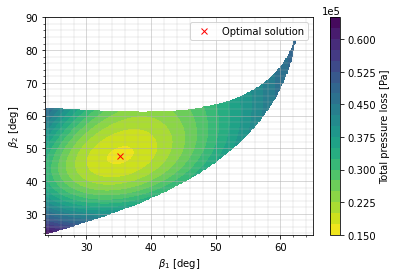

In [10]:
# Contour plot of the problem
plt.contourf(np.rad2deg(b1v), np.rad2deg(b2v), d, 20, cmap="viridis_r")
# Optimal solution in red X
plt.plot(np.rad2deg(beta1), np.rad2deg(beta2), "rx", label="Optimal solution")

# plt.title("Title")
plt.xlabel(r"$\beta_1$ [deg]")
plt.ylabel(r"$\beta_2$ [deg]")
plt.legend()

# Grid and ticks
plt.minorticks_on()
plt.grid(True, "major", "both", linewidth=0.5)
plt.grid(True, "minor", "both", linewidth=0.25)

# Color bar
cb = plt.colorbar(label="Total pressure loss [Pa]")
cb.formatter.set_scientific(True)
cb.formatter.set_powerlimits((5, 5))
cb.update_ticks()
plt.savefig("gradient.pdf", bbox_inches='tight')
plt.show()


In [11]:
data = np.array(list(flow.as_tuple() for flow in flows)).T
np.savetxt("data.csv", data, fmt="%8.5g", delimiter=" & ")


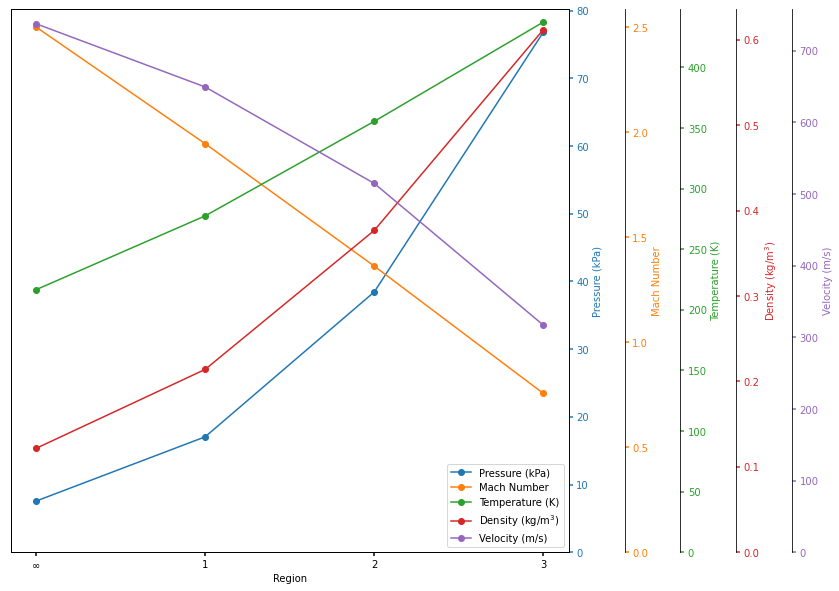

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
# fig.subplots_adjust(right=0.7)

data = np.array(list(flow.as_tuple() for flow in flows)).T
N = len(data)
labels = [
    "Pressure (kPa)",
    "Mach Number",
    "Temperature (K)",
    "Density (kg/m$^3$)",
    "Velocity (m/s)",
]
scales = [1e3, 1, 1, 1, 1]

axv = [ax.twinx() for i in range(N)]

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
# T_ax.spines["right"].set_position(("axes", 1.2))


pv = [
    axv[i].plot(data[i, :] / scales[i], "o-", color=f"C{i}", label=labels[i])[0]
    for i in range(N)
]


ax.set_xlabel("Region")
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([r"$\infty$", "1", "2", "3"])
ax.set_yticks([])
tkw = dict(size=4, width=1.5)

ax.tick_params(axis="x", **tkw)

for i in range(N):
    axv[i].set_ylabel(labels[i])
    axv[i].yaxis.label.set_color(pv[i].get_color())
    axv[i].tick_params(axis="y", colors=pv[i].get_color(), **tkw)
    axv[i].spines["right"].set_position(("axes", 1 + 0.10 * i))
    axv[i].set_ylim(ymin=0)


ax.legend(loc="lower right", handles=pv)
plt.savefig("properties.pdf", bbox_inches="tight")
plt.show()
